In [ ]:
!pip install transformers
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf
import transformers #huggingface transformers library

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.115.115.210:8470
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.115.115.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.115.115.210:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [ ]:
def remove_non_ascii(text):
    return ''.join([i if ord(i) < 128 else ' ' for i in text])
def remove_stopwords(text):
    cachedStopWords = stopwords.words("english")
    text = ' '.join([word for word in text.split() if word not in cachedStopWords])
    return text
def remove_punctuation(text):
    copy = re.sub(r'[^\w\s]', ' ', text)
    return copy
def remove_numbers(text):
    return re.sub(r'[0-9]+','',text)
def remove_links(text):
    return re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text, flags=re.MULTILINE)

def preprocessing(text):
    text = remove_non_ascii(text)
    text = remove_links(text)
    text = remove_numbers(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = text.lower()
    text = re.sub(r'\b\w{1,3}\b', '',text)
    return text

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
df = pd.read_json('/content/drive/MyDrive/output/data.json', lines = True)
for i in range(len(df.Content)):
    print(i)
    df.Content[i] =  preprocessing(df.Content[i])
    df.Title[i] = preprocessing(df.Title[i])
df.head()

Datele de ieșire de afișat au fost trunchiate la ultimele 5000 linii.
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738


,Category,Title,Keywords,Content
0,Artificial Intelligence,autonomous reciprocity context matters,NONE,continuing debate actionable ethics special i...
1,Artificial Intelligence,drones robots perceived autonomy implications ...,NONE,introductionthis special issue explores percei...
2,Artificial Intelligence,introduction special issue critical robotics r...,NONE,introductionin recent years design study robo...
3,Artificial Intelligence,service robots affective labor sociology labor...,"Affective labor, Human–robot interaction, Serv...",abstractprofit oriented service sectors touris...
4,Artificial Intelligence,like taking ball walk boundary work software ...,"Autonomy, Boundary work, Complexity, Software ...",abstractin paper explore choices boundary work...


In [ ]:
from langdetect import detect
count=0
notenglish = []
for i in range(len(df.Content)):
    if(detect(df.Content[i]) != "en"):
        print(i)
        notenglish.append(i)

1146
1568
3246
3745
5042
5045
5048
5050
5051
5052
5053
5054
5056
5059
5064
5074
5076
5077
5078
5079
5080
5081
5084
5094
5095
5096
5097
5120
5121
5122
5123
5124
5125
5126
5127
5133
5135
5136
5137
5139
5140
5141
5145
5146
5148
5149
5150
5152
5154
5155
5156
5161
5164
5171
5173
5179
5180
5181
5182
5183
5184
5185
5186
5189
5190
5191
5192
5193
5194
5195
5196
5197
5199
5201
5202
5211
5212
5213
5214
5215
5217
5219
5220
5221
5223
5224
5225
5230
5232
5233
5235
5236
5237
5245
5246
5247
5249
5250
5251
5252
5253
5260


In [ ]:
for i in range(len(notenglish)):
    df=df.drop(df.index[notenglish[i]-i])

In [ ]:
print(f"The dataset contains { df.Category.nunique() } unique categories")

The dataset contains 11 unique categories


In [ ]:
#label encoding the categories. After this each category would be mapped to an integer.
encoder = LabelEncoder()
df['categoryEncoded'] = encoder.fit_transform(df['Category'])

In [ ]:
#since I am using bert-large-uncased as the model, I am converting each of the news headlines and descriptions into lower case.
df['Title'] = df['Title'].apply(lambda headline: str(headline).lower())
df['Content'] = df['Content'].apply(lambda descr: str(descr).lower())

In [ ]:
#calculating the length of headlines and descriptions
df['descr_len'] = df['Content'].apply(lambda x: len(str(x).split()))
df['headline_len'] = df['Title'].apply(lambda x: len(str(x).split()))

In [ ]:
df = df[df.descr_len >= 2000]

In [ ]:
df.describe()

,categoryEncoded,descr_len,headline_len
count,6413.000000,6413.000000,6413.000000
mean,4.632621,4648.038983,8.484017
std,3.192817,2089.607189,2.875012
min,0.000000,2003.000000,1.000000
25%,2.000000,3257.000000,7.000000
50%,5.000000,4163.000000,8.000000
75%,7.000000,5469.000000,10.000000
max,10.000000,32595.000000,22.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


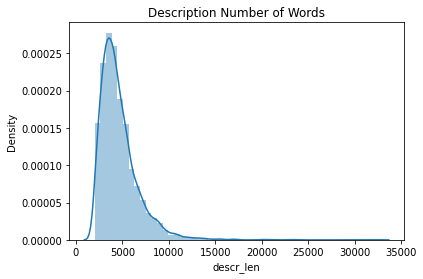

In [ ]:
sns.distplot(df['descr_len'])
plt.title('Description Number of Words')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


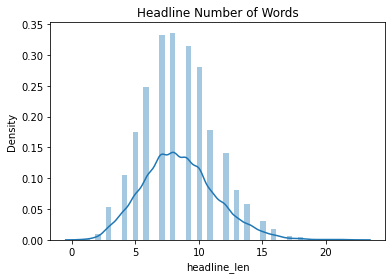

In [ ]:
sns.distplot(df['headline_len'])
plt.title('Headline Number of Words')
plt.show()

In [ ]:
df['Content'] = df['Title'] + " " + df['Content']

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


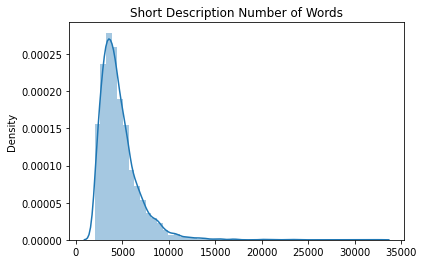

In [ ]:
sns.distplot(df['headline_len'] + df['descr_len'])
plt.title('Short Description Number of Words')
plt.show()

In [ ]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_masks=False, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])


In [ ]:
#bert large uncased pretrained tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased')

In [ ]:
X_train,X_test ,y_train,y_test = train_test_split(df['Content'], df['categoryEncoded'], random_state = 2020, test_size = 0.3)

In [ ]:
#tokenizing the news descriptions and converting the categories into one hot vectors using tf.keras.utils.to_categorical
Xtrain_encoded = regular_encode(X_train.astype('str'), tokenizer, maxlen=100)
ytrain_encoded = tf.keras.utils.to_categorical(y_train, num_classes=11,dtype = 'int32')
Xtest_encoded = regular_encode(X_test.astype('str'), tokenizer, maxlen=100)
ytest_encoded = tf.keras.utils.to_categorical(y_test, num_classes=11,dtype = 'int32')

Datele de ieșire de afișat au fost trunchiate la ultimele 5000 linii.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': F

In [ ]:
def build_model(transformer, loss='categorical_crossentropy', max_len=512):
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    #adding dropout layer
    x = tf.keras.layers.Dropout(0.3)(cls_token)
    #using a dense layer of 40 neurons as the number of unique categories is 40. 
    out = tf.keras.layers.Dense(11, activation='softmax')(x)
    model = tf.keras.Model(inputs=input_word_ids, outputs=out)
    #using categorical crossentropy as the loss as it is a multi-class classification problem
    model.compile(tf.keras.optimizers.Adam(lr=3e-5), loss=loss, metrics=['accuracy'])
    return model

In [ ]:
#building the model on tpu
with strategy.scope():
    transformer_layer = transformers.TFAutoModel.from_pretrained('bert-large-uncased')
    model = build_model(transformer_layer, max_len=100)
model.summary()

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 100)]            0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  335141888
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             100, 1024),                         
                              pooler_output=(None, 10            
                             24),                                
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#creating the training and testing dataset.
BATCH_SIZE = 32*strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE 
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((Xtrain_encoded, ytrain_encoded))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(Xtest_encoded)
    .batch(BATCH_SIZE)
)

In [ ]:
#training for 10 epochs
n_steps = Xtrain_encoded.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    epochs=10
)

Epoch 1/10


17/17 [==============================] - 183s 570ms/step - loss: 2.1842 - accuracy: 0.2397
Epoch 2/10
17/17 [==============================] - 10s 570ms/step - loss: 1.7994 - accuracy: 0.3495
Epoch 3/10
17/17 [==============================] - 10s 570ms/step - loss: 1.6200 - accuracy: 0.4042
Epoch 4/10
17/17 [==============================] - 10s 570ms/step - loss: 1.4740 - accuracy: 0.4364
Epoch 5/10
17/17 [==============================] - 10s 570ms/step - loss: 1.4090 - accuracy: 0.4616
Epoch 6/10
17/17 [==============================] - 10s 570ms/step - loss: 1.3106 - accuracy: 0.4966
Epoch 7/10
17/17 [==============================] - 10s 572ms/step - loss: 1.2165 - accuracy: 0.5205
Epoch 8/10
17/17 [==============================] - 10s 575ms/step - loss: 1.2151 - accuracy: 0.5165
Epoch 9/10
17/17 [==============================] - 10s 570ms/step - loss: 1.0990 - accuracy: 0.5547
Epoch 10/10
17/17 [==============================] - 10s 570ms/step - loss: 0.9749 - accuracy: 0.5988

In [ ]:
#making predictions
preds = model.predict(test_dataset,verbose = 1)
#converting the one hot vector output to a linear numpy array.
pred_classes = np.argmax(preds, axis = 1)

8/8 [==============================] - 35s 4s/step


In [ ]:
#extracting the classes from the label encoder
encoded_classes = encoder.classes_
#mapping the encoded output to actual categories
predicted_category = [encoded_classes[x] for x in pred_classes]
true_category = [encoded_classes[x] for x in y_test]

In [ ]:
result_df = pd.DataFrame({'description':X_test,'true_category':true_category, 'predicted_category':predicted_category})
result_df.head()

,description,true_category,predicted_category
128,generalized weisfeiler lehman graph kernel ab...,Artificial Intelligence,Computational Theory and Mathematics
6521,manifesto human centric explainable approach f...,Information Systems,Artificial Intelligence
6112,blockchain covid comprehensive review abstract...,Human-Computer Interaction,Computer Networks and Communications
7840,formal verification component specifications ...,Software,Software
6584,improved firefly algorithm courtship learning ...,Information Systems,Computer Networks and Communications


In [ ]:
print(f"Accuracy is {sklearn.metrics.accuracy_score(result_df['true_category'], result_df['predicted_category'])}")

Accuracy is 0.36434511434511435


In [ ]:
print(sklearn.metrics.classification_report(result_df['true_category'], result_df['predicted_category']))

                                             precision    recall  f1-score   support

                    Artificial Intelligence       0.32      0.40      0.36       224
       Computational Theory and Mathematics       0.68      0.62      0.65       224
Computer Graphics and Computer-Aided Design       0.23      0.36      0.28       104
       Computer Networks and Communications       0.39      0.42      0.41       246
              Computer Science Applications       0.41      0.50      0.45       102
    Computer Vision and Pattern Recognition       0.22      0.18      0.20       239
                  Hardware and Architecture       0.29      0.18      0.22        57
                 Human-Computer Interaction       0.27      0.17      0.21       248
                        Information Systems       0.34      0.37      0.36       268
                          Signal Processing       0.33      0.24      0.28        79
                                   Software       0.43      0.51

In [ ]:
print(sklearn.metrics.top_k_accuracy_score(result_df['true_category'], preds, k=3))

0.8009355509355509


In [ ]:
result_df.to_csv('testPredictions.csv', index = False)

In [ ]:
result_df[result_df['true_category']!=result_df['predicted_category']]

In [ ]:
confusion_mat = confusion_matrix(y_true = true_category, y_pred = predicted_category, labels=list(encoded_classes))

In [ ]:
df_cm = pd.DataFrame(confusion_mat, index = list(encoded_classes),columns = list(encoded_classes))
plt.rcParams['figure.figsize'] = (20,20)
sns.heatmap(df_cm)